In [1]:
from composer.algorithms import ChannelsLastHparams
from composer.callbacks import LRMonitorHparams
from composer.core.time import Time
from composer.core.types import DataLoader
from composer.datasets import DataLoaderHparams
from composer.loggers import WandBLoggerHparams
from composer.models import ComposerClassifier
from composer.optim import (SGDHparams, ConstantSchedulerHparams, CosineAnnealingSchedulerHparams, 
                            CosineAnnealingWithWarmupSchedulerHparams, MultiStepSchedulerHparams, 
                            MultiStepWithWarmupSchedulerHparams)
from composer.trainer import Trainer, TrainerHparams
from composer.utils.object_store import ObjectStoreProviderHparams, ObjectStoreProvider
from copy import deepcopy
from lth_diet.data import CIFAR10DataHparams, DataHparams, CINIC10DataHparams
from lth_diet.exps import LotteryExperiment, LotteryRetrainExperiment
from lth_diet.models import ResNetCIFARClassifierHparams, ClassifierHparams
from lth_diet.pruning import Mask, PrunedClassifier, PruningHparams
from lth_diet.pruning.pruned_classifier import prunable_layer_names
from lth_diet.utils import utils
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import torch
from tqdm import tqdm
from typing import Callable, Dict, Tuple
plt.style.use("default")
rc = {"figure.figsize": (4, 3), "figure.dpi": 150, "figure.constrained_layout.use": True, "axes.grid": True, 
      "axes.spines.right": False, "axes.spines.top": False, "axes.linewidth": 0.6, "grid.linewidth": 0.6,
      "xtick.major.width": 0.6, "ytick.major.width": 0.6, "xtick.major.size": 4, "ytick.major.size": 4, 
      "axes.labelsize": 11, "axes.titlesize": 11, "xtick.labelsize": 10, "ytick.labelsize": 10,
      "axes.titlepad": 4, "axes.labelpad": 2, "xtick.major.pad": 2, "ytick.major.pad": 2,
      "lines.linewidth": 1.2, "patch.linewidth": 0}
sns.set_theme(style='ticks', palette=sns.color_palette("colorblind"), rc=rc)
object_store = ObjectStoreProviderHparams('google_storage', 'prunes', 'GCS_KEY').initialize_object()
bucket_dir = os.environ['OBJECT_STORE_DIR']

In [2]:
torch.set_grad_enabled(False)

In [3]:
config = f"../configs/lottery_cinic10_retrain.yaml"
exp = LotteryRetrainExperiment.create(f=config, cli_args=False)
load_replicates = [0, 1]
replicates = [0, 1]
rewinding_steps = [0, 200, 400, 800]
model_hparams = ResNetCIFARClassifierHparams(10, 56)
train_data = CINIC10DataHparams(True,False,False,True,).initialize_object(1000, DataLoaderHparams(persistent_workers=False))
test_data = CINIC10DataHparams(False).initialize_object(1000, DataLoaderHparams(persistent_workers=False))

In [4]:
def losses_and_state_dict(location, name, train_data):
    state_dict = utils.load_object(location, name, object_store, torch.load)
    model = model_hparams.initialize_object()
    model.module.load_state_dict(state_dict)
    print(f"      Loaded {utils.get_object_name(location, name)}")
    losses = []
    model.cuda()
    model.eval()
    for batch in train_data:
        batch = batch[0].cuda(), batch[1].cuda()
        logits = model(batch)
        losses.append(torch.nn.CrossEntropyLoss(reduction="none")(logits, batch[1])) 
    losses = torch.cat(losses).cpu().numpy()
    print(f"      Evaluated {utils.get_object_name(location, name)}")
    return losses, state_dict

def losses_only(state_dict, train_data):
    model = model_hparams.initialize_object()
    model.module.load_state_dict(state_dict)
    losses = []
    model.cuda()
    model.eval()
    for batch in train_data:
        batch = batch[0].cuda(), batch[1].cuda()
        logits = model(batch)
        losses.append(torch.nn.CrossEntropyLoss(reduction="none")(logits, batch[1])) 
    losses = torch.cat(losses).cpu().numpy()
    print(f"      Evaluated midpoint")
    return losses

def midpoint(state_dict: Dict, state_dict_: Dict) -> Dict:
    """Return the midpoint between two state dicts"""
    state_dict__ = {}
    for k, v in state_dict.items():
        state_dict__[k] = (v + state_dict_[k]) / 2
    return state_dict__

In [5]:
# train_loss_barriers = np.zeros((len(rewinding_steps), len(load_replicates), 3, 180000))
# for i, rstep in enumerate(rewinding_steps):
#     print("rewinding step:", rstep)
#     for j, lrep in enumerate(load_replicates):
#         print("  replicate:", lrep)
#         # setup experiment
#         exp.load_exp.rewinding_steps = f"{rstep}ba"
#         exp.load_replicate = lrep
#         # parent
#         location = f"{utils.get_hash(exp.load_exp.name)}/replicate_{lrep}/level_0/main"
#         losses_, state_dict_ = losses_and_state_dict(location, "model_final.pt", train_data)
#         # child 0 
#         location = f"{utils.get_hash(exp.load_exp.name)}/replicate_{lrep}/level_0/{utils.get_hash(exp.name)}/replicate_{0}/main"
#         losses_0, state_dict_0 = losses_and_state_dict(location, "model_final.pt", train_data)
#         # child 0 
#         location = f"{utils.get_hash(exp.load_exp.name)}/replicate_{lrep}/level_0/{utils.get_hash(exp.name)}/replicate_{1}/main"
#         losses_1, state_dict_1 = losses_and_state_dict(location, "model_final.pt", train_data)
#         # midpoint 0
#         state_dict = midpoint(state_dict_, state_dict_0)
#         losses = losses_only(state_dict, train_data)
#         train_loss_barriers[i, j, 0] = losses - (losses_ + losses_0) / 2
#         # midpoint 1
#         state_dict = midpoint(state_dict_, state_dict_1)
#         losses = losses_only(state_dict, train_data)
#         train_loss_barriers[i, j, 1] = losses - (losses_ + losses_1) / 2
#         # midpoint 2
#         state_dict = midpoint(state_dict_0, state_dict_1)
#         losses = losses_only(state_dict, train_data)
#         train_loss_barriers[i, j, 2] = losses - (losses_0 + losses_1) / 2
# np.save("baseline_train_loss_barriers.npy", train_loss_barriers)


In [6]:
def get_acc(location, name, data):
    state_dict = utils.load_object(location, name, object_store, torch.load)
    model = model_hparams.initialize_object()
    model.module.load_state_dict(state_dict)
    print(f"      Loaded {utils.get_object_name(location, name)}")
    correct = 0
    model.cuda()
    model.eval()
    correct = 0
    for batch in data:
        batch = batch[0].cuda(), batch[1].cuda()
        logits = model(batch)
        correct += (logits.argmax(dim=-1) == batch[1]).sum()
    model.cpu()
    return (correct / len(data.dataset)).item()

In [7]:
# pretrain_test_accs = np.zeros([len(rewinding_steps), len(replicates)])
# for i, rstep in enumerate(rewinding_steps):
#     print("rewinding step:", rstep)
#     for j, lrep in enumerate(load_replicates):
#         print("  replicate:", lrep)
#         # setup experiment
#         exp.load_exp.rewinding_steps = f"{rstep}ba"
#         exp.load_replicate = lrep
#         # pretrain model accuracy
#         location = f"{utils.get_hash(exp.load_exp.name)}/replicate_{lrep}/level_0/main"
#         pretrain_test_accs[i, j] = get_acc(location, "model_init.pt", test_data)
# np.save("baseline_pretrain_test_accs.npy", pretrain_test_accs)

In [8]:
def get_accuracy_val(exp, num_reps, object_store, level):
    exp_hash = utils.get_hash(exp.name)
    num_reps_seen = 0
    steps_rt, accs_rt = [], []
    for rep in range(num_reps):
        if utils.object_exists_in_bucket(
            f"{bucket_dir}/{exp_hash}/replicate_{rep}/level_{level}/main/log.txt", object_store
        ):
            num_reps_seen += 1
            object_store.download_object(
                f"{bucket_dir}/{exp_hash}/replicate_{rep}/level_{level}/main/log.txt", "temp.txt"
            )
            log = pd.read_table("temp.txt", header=None)[0]
            os.remove("temp.txt")
            steps_t, accs_t = [], []
            for line in log:
                match = re.search('\[EPOCH\]\[step=(\d*)\]: { "accuracy/val": ([+-]?[0-9]*[.]?[0-9]+), \}', line)
                if match:
                    steps_t.append(int(match.group(1)))
                    accs_t.append(float(match.group(2)))
            steps_rt.append(steps_t)
            accs_rt.append(accs_t)
            if num_reps_seen == 2:
                break
    steps_rt, accs_rt = np.array(steps_rt), np.array(accs_rt)
    return steps_rt, accs_rt

In [9]:
# config = f"../configs/lottery_cinic10.yaml"
# num_replicates = 2
# rewinding_steps = ["0ba", "200ba", "400ba", "800ba"]
# num_levels = 16
# lrs = [0.1]
# exp = LotteryExperiment.create(f=config, cli_args=False)

In [10]:
# accs__lr_rew_lvl_rep = []
# for lr in lrs:
#     print(lr)
#     accs__rew_lvl_rep = []
#     for rs in tqdm(rewinding_steps):
#         accs__lvl_rep = []
#         for lvl in range(num_levels+1):
#             exp.pretrain_optimizer.lr = lr
#             exp.rewinding_steps = rs
#             _, accs_rt = get_accuracy_val(exp, num_replicates, object_store, lvl)
#             accs__lvl_rep.append(accs_rt[:, -1])
#         accs__rew_lvl_rep.append(accs__lvl_rep)
#     accs__lr_rew_lvl_rep.append(accs__rew_lvl_rep)
# sparse_test_accs = np.array(accs__lr_rew_lvl_rep).squeeze()
# np.save("baseline_sparse_test_accs.npy", sparse_test_accs)

In [11]:
# config = f"../configs/lottery_cinic10_easy_retrain.yaml"
# exp = LotteryRetrainExperiment.create(f=config, cli_args=False)
# load_replicates = [0, 1]
# replicates = [0, 1]
# rewinding_steps = [200, 400]
# sizes = [12800, 25600, 51200]
# train_loss_barriers = np.zeros((len(sizes), len(rewinding_steps), len(load_replicates), 3, 180000))
# for k, size in enumerate(sizes):
#     print("size", size)
#     for i, rstep in enumerate(rewinding_steps):
#         print("rewinding step:", rstep)
#         for j, lrep in enumerate(load_replicates):
#             print("  replicate:", lrep)
#             # setup experiment
#             exp.load_exp.rewinding_steps = f"{rstep}ba"
#             exp.load_replicate = lrep
#             exp.load_exp.pretrain_data.dataset_transforms[0].size = size
#             # parent
#             location = f"{utils.get_hash(exp.load_exp.name)}/replicate_{lrep}/level_0/main"
#             losses_, state_dict_ = losses_and_state_dict(location, "model_final.pt", train_data)
#             # child 0 
#             location = f"{utils.get_hash(exp.load_exp.name)}/replicate_{lrep}/level_0/{utils.get_hash(exp.name)}/replicate_{0}/main"
#             losses_0, state_dict_0 = losses_and_state_dict(location, "model_final.pt", train_data)
#             # child 0 
#             location = f"{utils.get_hash(exp.load_exp.name)}/replicate_{lrep}/level_0/{utils.get_hash(exp.name)}/replicate_{1}/main"
#             losses_1, state_dict_1 = losses_and_state_dict(location, "model_final.pt", train_data)
#             # midpoint 0
#             state_dict = midpoint(state_dict_, state_dict_0)
#             losses = losses_only(state_dict, train_data)
#             train_loss_barriers[k, i, j, 0] = losses - (losses_ + losses_0) / 2
#             # midpoint 1
#             state_dict = midpoint(state_dict_, state_dict_1)
#             losses = losses_only(state_dict, train_data)
#             train_loss_barriers[k, i, j, 1] = losses - (losses_ + losses_1) / 2
#             # midpoint 2
#             state_dict = midpoint(state_dict_0, state_dict_1)
#             losses = losses_only(state_dict, train_data)
#             train_loss_barriers[k, i, j, 2] = losses - (losses_0 + losses_1) / 2
# np.save("easy_train_loss_barriers.npy", train_loss_barriers)

In [12]:
# config = f"../configs/lottery_cinic10_easy_retrain.yaml"
# exp = LotteryRetrainExperiment.create(f=config, cli_args=False)
# load_replicates = [0, 1]
# replicates = [0, 1]
# rewinding_steps = [200, 400]
# sizes = [12800, 25600, 51200]
# pretrain_test_accs = np.zeros([len(sizes), len(rewinding_steps), len(replicates)])
# for k, size in enumerate(sizes):
#     print("size", size)
#     for i, rstep in enumerate(rewinding_steps):
#         print("rewinding step:", rstep)
#         for j, lrep in enumerate(load_replicates):
#             print("  replicate:", lrep)
#             # setup experiment
#             exp.load_exp.rewinding_steps = f"{rstep}ba"
#             exp.load_replicate = lrep
#             exp.load_exp.pretrain_data.dataset_transforms[0].size = size
#             # pretrain model accuracy
#             location = f"{utils.get_hash(exp.load_exp.name)}/replicate_{lrep}/level_0/main"
#             pretrain_test_accs[k, i, j] = get_acc(location, "model_init.pt", test_data)
# np.save("easy_pretrain_test_accs.npy", pretrain_test_accs)

In [13]:
# config = f"../configs/lottery_cinic10_easy.yaml"
# num_replicates = 2
# rewinding_steps = ["200ba", "400ba"]
# num_levels = 16
# sizes = [12800, 25600, 51200]
# exp = LotteryExperiment.create(f=config, cli_args=False)
# accs__lr_rew_lvl_rep = []
# for size in sizes:
#     print(size)
#     accs__rew_lvl_rep = []
#     for rs in tqdm(rewinding_steps):
#         accs__lvl_rep = []
#         for lvl in range(num_levels+1):
#             exp.pretrain_data.dataset_transforms[0].size = size
#             exp.rewinding_steps = rs
#             _, accs_rt = get_accuracy_val(exp, num_replicates, object_store, lvl)
#             accs__lvl_rep.append(accs_rt[:, -1])
#         accs__rew_lvl_rep.append(accs__lvl_rep)
#     accs__lr_rew_lvl_rep.append(accs__rew_lvl_rep)
# sparse_test_accs = np.array(accs__lr_rew_lvl_rep).squeeze()
# np.save("easy_sparse_test_accs.npy", sparse_test_accs)

In [14]:
# config = f"../configs/lottery_cinic10_random_retrain.yaml"
# exp = LotteryRetrainExperiment.create(f=config, cli_args=False)
# load_replicates = [0, 1]
# replicates = [0, 1]
# rewinding_steps = [200, 400]
# sizes = [12800, 25600, 51200]
# train_loss_barriers = np.zeros((len(sizes), len(rewinding_steps), len(load_replicates), 3, 180000))
# for k, size in enumerate(sizes):
#     print("size", size)
#     for i, rstep in enumerate(rewinding_steps):
#         print("rewinding step:", rstep)
#         for j, lrep in enumerate(load_replicates):
#             print("  replicate:", lrep)
#             # setup experiment
#             exp.load_exp.rewinding_steps = f"{rstep}ba"
#             exp.load_replicate = lrep
#             exp.load_exp.pretrain_data.dataset_transforms[0].size = size
#             # parent
#             location = f"{utils.get_hash(exp.load_exp.name)}/replicate_{lrep}/level_0/main"
#             losses_, state_dict_ = losses_and_state_dict(location, "model_final.pt", train_data)
#             # child 0 
#             location = f"{utils.get_hash(exp.load_exp.name)}/replicate_{lrep}/level_0/{utils.get_hash(exp.name)}/replicate_{0}/main"
#             losses_0, state_dict_0 = losses_and_state_dict(location, "model_final.pt", train_data)
#             # child 0 
#             location = f"{utils.get_hash(exp.load_exp.name)}/replicate_{lrep}/level_0/{utils.get_hash(exp.name)}/replicate_{1}/main"
#             losses_1, state_dict_1 = losses_and_state_dict(location, "model_final.pt", train_data)
#             # midpoint 0
#             state_dict = midpoint(state_dict_, state_dict_0)
#             losses = losses_only(state_dict, train_data)
#             train_loss_barriers[k, i, j, 0] = losses - (losses_ + losses_0) / 2
#             # midpoint 1
#             state_dict = midpoint(state_dict_, state_dict_1)
#             losses = losses_only(state_dict, train_data)
#             train_loss_barriers[k, i, j, 1] = losses - (losses_ + losses_1) / 2
#             # midpoint 2
#             state_dict = midpoint(state_dict_0, state_dict_1)
#             losses = losses_only(state_dict, train_data)
#             train_loss_barriers[k, i, j, 2] = losses - (losses_0 + losses_1) / 2
# np.save("random_train_loss_barriers.npy", train_loss_barriers)

In [15]:
# config = f"../configs/lottery_cinic10_random_retrain.yaml"
# exp = LotteryRetrainExperiment.create(f=config, cli_args=False)
# load_replicates = [0, 1]
# replicates = [0, 1]
# rewinding_steps = [200, 400]
# sizes = [12800, 25600, 51200]
# pretrain_test_accs = np.zeros([len(sizes), len(rewinding_steps), len(replicates)])
# for k, size in enumerate(sizes):
#     print("size", size)
#     for i, rstep in enumerate(rewinding_steps):
#         print("rewinding step:", rstep)
#         for j, lrep in enumerate(load_replicates):
#             print("  replicate:", lrep)
#             # setup experiment
#             exp.load_exp.rewinding_steps = f"{rstep}ba"
#             exp.load_replicate = lrep
#             exp.load_exp.pretrain_data.dataset_transforms[0].size = size
#             # pretrain model accuracy
#             location = f"{utils.get_hash(exp.load_exp.name)}/replicate_{lrep}/level_0/main"
#             pretrain_test_accs[k, i, j] = get_acc(location, "model_init.pt", test_data)
# np.save("random_pretrain_test_accs.npy", pretrain_test_accs)

In [16]:
# config = f"../configs/lottery_cinic10_random.yaml"
# num_replicates = 2
# rewinding_steps = ["200ba", "400ba"]
# num_levels = 16
# sizes = [12800, 25600, 51200]
# exp = LotteryExperiment.create(f=config, cli_args=False)
# accs__lr_rew_lvl_rep = []
# for size in sizes:
#     print(size)
#     accs__rew_lvl_rep = []
#     for rs in tqdm(rewinding_steps):
#         accs__lvl_rep = []
#         for lvl in range(num_levels+1):
#             exp.pretrain_data.dataset_transforms[0].size = size
#             exp.rewinding_steps = rs
#             _, accs_rt = get_accuracy_val(exp, num_replicates, object_store, lvl)
#             accs__lvl_rep.append(accs_rt[:, -1])
#         accs__rew_lvl_rep.append(accs__lvl_rep)
#     accs__lr_rew_lvl_rep.append(accs__rew_lvl_rep)
# sparse_test_accs = np.array(accs__lr_rew_lvl_rep).squeeze()
# np.save("random_sparse_test_accs.npy", sparse_test_accs)

In [31]:
config = f"../configs/lottery_cinic10_lmc800_retrain.yaml"
exp = LotteryRetrainExperiment.create(f=config, cli_args=False)
load_replicates = [0, 1]
replicates = [0, 1]
rewinding_steps = [400]
sizes = [12800, 25600, 51200]
train_loss_barriers = np.zeros((len(sizes), len(rewinding_steps), len(load_replicates), 3, 180000))
for k, size in enumerate(sizes):
    print("size", size)
    for i, rstep in enumerate(rewinding_steps):
        print("rewinding step:", rstep)
        for j, lrep in enumerate(load_replicates):
            print("  replicate:", lrep)
            # setup experiment
            exp.load_exp.rewinding_steps = f"{rstep}ba"
            exp.load_replicate = lrep
            exp.load_exp.pretrain_data.dataset_transforms[0].size = size
            # parent
            location = f"{utils.get_hash(exp.load_exp.name)}/replicate_{lrep}/level_0/main"
            losses_, state_dict_ = losses_and_state_dict(location, "model_final.pt", train_data)
            # child 0 
            location = f"{utils.get_hash(exp.load_exp.name)}/replicate_{lrep}/level_0/{utils.get_hash(exp.name)}/replicate_{0}/main"
            losses_0, state_dict_0 = losses_and_state_dict(location, "model_final.pt", train_data)
            # child 0 
            location = f"{utils.get_hash(exp.load_exp.name)}/replicate_{lrep}/level_0/{utils.get_hash(exp.name)}/replicate_{1}/main"
            losses_1, state_dict_1 = losses_and_state_dict(location, "model_final.pt", train_data)
            # midpoint 0
            state_dict = midpoint(state_dict_, state_dict_0)
            losses = losses_only(state_dict, train_data)
            train_loss_barriers[k, i, j, 0] = losses - (losses_ + losses_0) / 2
            # midpoint 1
            state_dict = midpoint(state_dict_, state_dict_1)
            losses = losses_only(state_dict, train_data)
            train_loss_barriers[k, i, j, 1] = losses - (losses_ + losses_1) / 2
            # midpoint 2
            state_dict = midpoint(state_dict_0, state_dict_1)
            losses = losses_only(state_dict, train_data)
            train_loss_barriers[k, i, j, 2] = losses - (losses_0 + losses_1) / 2
np.save("lmc800_train_loss_barriers.npy", train_loss_barriers)

size 12800
rewinding step: 400
  replicate: 0
      Loaded lth_diet/405389633bdae3e671c9730be4ac96e7/replicate_0/level_0/main/model_final.pt
      Evaluated lth_diet/405389633bdae3e671c9730be4ac96e7/replicate_0/level_0/main/model_final.pt
      Loaded lth_diet/405389633bdae3e671c9730be4ac96e7/replicate_0/level_0/b085dfbc49541e80b674b3ffd24a144f/replicate_0/main/model_final.pt
      Evaluated lth_diet/405389633bdae3e671c9730be4ac96e7/replicate_0/level_0/b085dfbc49541e80b674b3ffd24a144f/replicate_0/main/model_final.pt
      Loaded lth_diet/405389633bdae3e671c9730be4ac96e7/replicate_0/level_0/b085dfbc49541e80b674b3ffd24a144f/replicate_1/main/model_final.pt
      Evaluated lth_diet/405389633bdae3e671c9730be4ac96e7/replicate_0/level_0/b085dfbc49541e80b674b3ffd24a144f/replicate_1/main/model_final.pt
      Evaluated midpoint
      Evaluated midpoint
      Evaluated midpoint
  replicate: 1
      Loaded lth_diet/405389633bdae3e671c9730be4ac96e7/replicate_1/level_0/main/model_final.pt
      Eval

In [32]:
config = f"../configs/lottery_cinic10_lmc800_retrain.yaml"
exp = LotteryRetrainExperiment.create(f=config, cli_args=False)
load_replicates = [0, 1]
replicates = [0, 1]
rewinding_steps = [400]
sizes = [12800, 25600, 51200]
pretrain_test_accs = np.zeros([len(sizes), len(rewinding_steps), len(replicates)])
for k, size in enumerate(sizes):
    print("size", size)
    for i, rstep in enumerate(rewinding_steps):
        print("rewinding step:", rstep)
        for j, lrep in enumerate(load_replicates):
            print("  replicate:", lrep)
            # setup experiment
            exp.load_exp.rewinding_steps = f"{rstep}ba"
            exp.load_replicate = lrep
            exp.load_exp.pretrain_data.dataset_transforms[0].size = size
            # pretrain model accuracy
            location = f"{utils.get_hash(exp.load_exp.name)}/replicate_{lrep}/level_0/main"
            pretrain_test_accs[k, i, j] = get_acc(location, "model_init.pt", test_data)
np.save("lmc800_pretrain_test_accs.npy", pretrain_test_accs)

size 12800
rewinding step: 400
  replicate: 0
      Loaded lth_diet/405389633bdae3e671c9730be4ac96e7/replicate_0/level_0/main/model_init.pt
  replicate: 1
      Loaded lth_diet/405389633bdae3e671c9730be4ac96e7/replicate_1/level_0/main/model_init.pt
size 25600
rewinding step: 400
  replicate: 0
      Loaded lth_diet/10fa32af12a2ac8b88dabf04af514c86/replicate_0/level_0/main/model_init.pt
  replicate: 1
      Loaded lth_diet/10fa32af12a2ac8b88dabf04af514c86/replicate_1/level_0/main/model_init.pt
size 51200
rewinding step: 400
  replicate: 0
      Loaded lth_diet/1b3b17956f2f7342dfc30668892f593e/replicate_0/level_0/main/model_init.pt
  replicate: 1
      Loaded lth_diet/1b3b17956f2f7342dfc30668892f593e/replicate_1/level_0/main/model_init.pt


In [33]:
config = f"../configs/lottery_cinic10_lmc800.yaml"
num_replicates = 2
rewinding_steps = ["400ba"]
num_levels = 16
sizes = [12800, 25600, 51200]
exp = LotteryExperiment.create(f=config, cli_args=False)
accs__lr_rew_lvl_rep = []
for size in sizes:
    print(size)
    accs__rew_lvl_rep = []
    for rs in tqdm(rewinding_steps):
        accs__lvl_rep = []
        for lvl in range(num_levels+1):
            exp.pretrain_data.dataset_transforms[0].size = size
            exp.rewinding_steps = rs
            _, accs_rt = get_accuracy_val(exp, num_replicates, object_store, lvl)
            accs__lvl_rep.append(accs_rt[:, -1])
        accs__rew_lvl_rep.append(accs__lvl_rep)
    accs__lr_rew_lvl_rep.append(accs__rew_lvl_rep)
sparse_test_accs = np.array(accs__lr_rew_lvl_rep).squeeze()
np.save("lmc800_sparse_test_accs.npy", sparse_test_accs)

12800


100%|██████████| 1/1 [00:33<00:00, 33.10s/it]


25600


100%|██████████| 1/1 [00:40<00:00, 40.93s/it]


51200


100%|██████████| 1/1 [00:32<00:00, 32.55s/it]


In [34]:
baseline_train_loss_barriers = np.load("baseline_train_loss_barriers.npy")
baseline_pretrain_test_accs = np.load("baseline_pretrain_test_accs.npy")
baseline_sparse_test_accs = np.load("baseline_sparse_test_accs.npy")
easy_train_loss_barriers = np.load("easy_train_loss_barriers.npy")
easy_pretrain_test_accs = np.load("easy_pretrain_test_accs.npy")
easy_sparse_test_accs = np.load("easy_sparse_test_accs.npy")
random_train_loss_barriers = np.load("random_train_loss_barriers.npy")
random_pretrain_test_accs = np.load("random_pretrain_test_accs.npy")
random_sparse_test_accs = np.load("random_sparse_test_accs.npy")
lmc1600_train_loss_barriers = np.load("lmc1600_train_loss_barriers.npy")
lmc1600_pretrain_test_accs = np.load("lmc1600_pretrain_test_accs.npy")
lmc1600_sparse_test_accs = np.load("lmc1600_sparse_test_accs.npy")
lmc800_train_loss_barriers = np.load("lmc800_train_loss_barriers.npy")
lmc800_pretrain_test_accs = np.load("lmc800_pretrain_test_accs.npy")
lmc800_sparse_test_accs = np.load("lmc800_sparse_test_accs.npy")


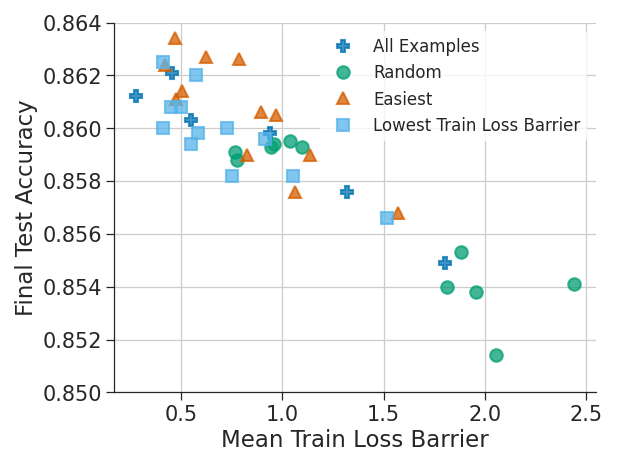

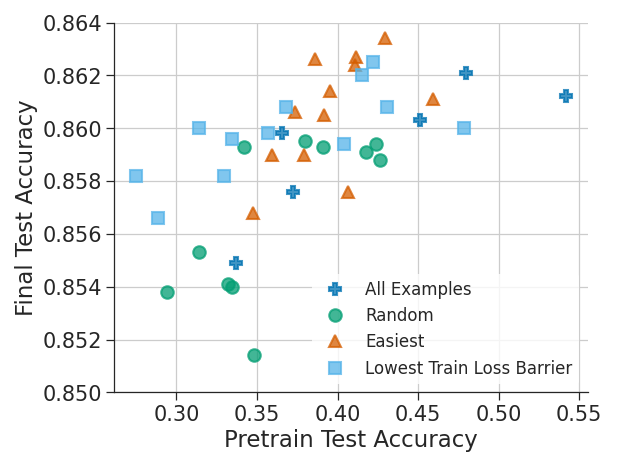

In [76]:
level = 7
plt.figure()
plt.plot(baseline_train_loss_barriers[1:].mean(-1).mean(-1).flatten(), baseline_sparse_test_accs[1:, level].flatten(), "C0P", alpha=0.75, label="All Examples")
plt.plot(random_train_loss_barriers.mean(-1).mean(-1).flatten(), random_sparse_test_accs[:, :, level].flatten(), "C2o", alpha=0.75, label="Random")
plt.plot(easy_train_loss_barriers.mean(-1).mean(-1).flatten(), easy_sparse_test_accs[:, :, level].flatten(), "C3^", alpha=0.75, label="Easiest")
plt.plot(lmc1600_train_loss_barriers.mean(-1).mean(-1).flatten(), lmc1600_sparse_test_accs[:, level].flatten(), "C9s", alpha=0.75, label="Lowest Train Loss Barrier")
plt.plot(lmc800_train_loss_barriers.mean(-1).mean(-1).flatten(), lmc800_sparse_test_accs[:, level].flatten(), "C9s", alpha=0.75)
plt.legend(fontsize=8)
plt.ylim(0.85, 0.864)
plt.xlabel("Mean Train Loss Barrier")
plt.ylabel("Final Test Accuracy")
plt.savefig("lmc.svg")
plt.figure()
plt.plot(baseline_pretrain_test_accs[1:].flatten(), baseline_sparse_test_accs[1:, level].flatten(), "C0P", alpha=0.75, label="All Examples")
plt.plot(random_pretrain_test_accs.flatten(), random_sparse_test_accs[:, :, level].flatten(), "C2o", alpha=0.75, label="Random")
plt.plot(easy_pretrain_test_accs.flatten(), easy_sparse_test_accs[:, :, level].flatten(), "C3^", alpha=0.75, label="Easiest")
plt.plot(lmc1600_pretrain_test_accs.flatten(), lmc1600_sparse_test_accs[:, level].flatten(), "C9s", alpha=0.75, label="Lowest Train Loss Barrier")
plt.plot(lmc800_pretrain_test_accs.flatten(), lmc800_sparse_test_accs[:, level].flatten(), "C9s", alpha=0.75)
plt.legend(fontsize=8)
plt.ylim(0.85, 0.864)
plt.xlabel("Pretrain Test Accuracy")
plt.ylabel("Final Test Accuracy")
plt.savefig("acc.svg")


In [122]:
baseline_train_loss_barriers[1].shape, random_train_loss_barriers[2, 0].shape

((2, 3, 180000), (2, 3, 180000))

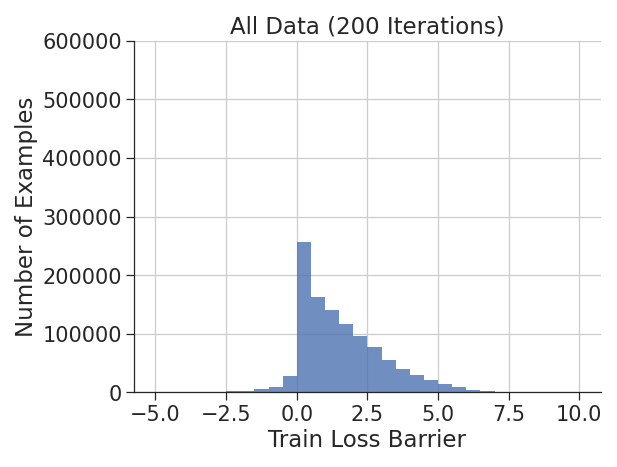

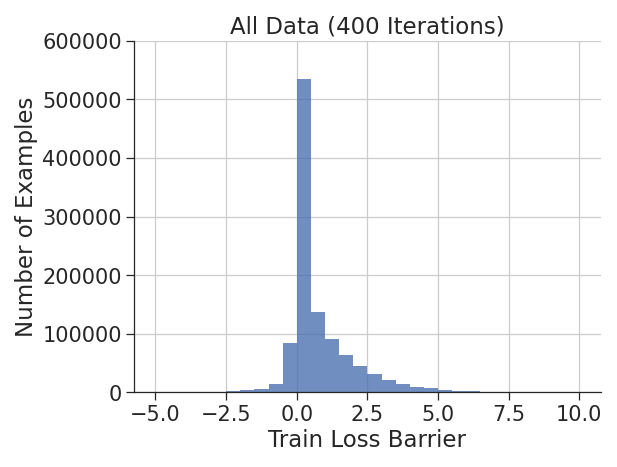

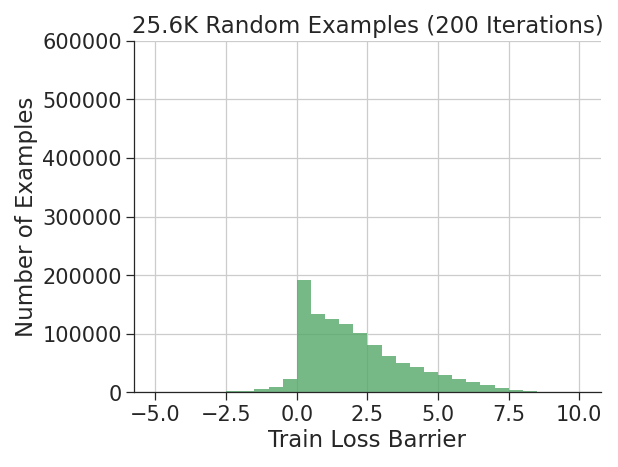

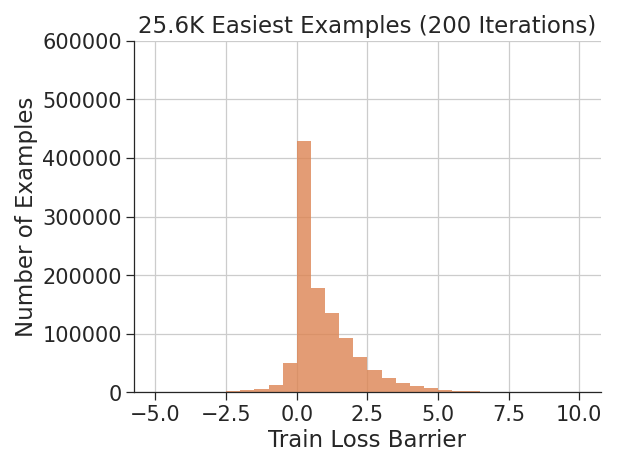

In [139]:
sns.set_theme(style='ticks', palette=sns.color_palette("deep"), rc=rc)
plt.figure()
plt.hist(baseline_train_loss_barriers[1].flatten(), bins=np.linspace(-5, 10, 31), alpha=0.8, color="C0")
plt.ylim(0, 600000)
plt.xlabel("Train Loss Barrier")
plt.ylabel("Number of Examples")
plt.title("All Data (200 Iterations)")
plt.savefig("0.svg")
plt.figure()
plt.hist(baseline_train_loss_barriers[2].flatten(), bins=np.linspace(-5, 10, 31), alpha=0.8, color="C0")
plt.ylim(0, 600000)
plt.xlabel("Train Loss Barrier")
plt.ylabel("Number of Examples")
plt.title("All Data (400 Iterations)")
plt.savefig("1.svg")
plt.figure()
plt.hist(random_train_loss_barriers[1,0].flatten(), bins=np.linspace(-5, 10, 31), alpha=0.8, color="C2")
plt.ylim(0, 600000)
plt.xlabel("Train Loss Barrier")
plt.ylabel("Number of Examples")
plt.title("25.6K Random Examples (200 Iterations)")
plt.savefig("2.svg")
plt.figure()
plt.hist(easy_train_loss_barriers[1,0].flatten(), bins=np.linspace(-5, 10, 31), alpha=0.8, color="C1")
plt.ylim(0, 600000)
plt.xlabel("Train Loss Barrier")
plt.ylabel("Number of Examples")
plt.title("25.6K Easiest Examples (200 Iterations)")
plt.savefig("3.svg")

In [96]:
random_train_loss_barriers.shape

(3, 2, 2, 3, 180000)